In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from gtfs_merida import GTFSMerida

datos = "../datos"
gtfs_base_file = f"{datos}/GTFS/gtfs-merida.zip"
isocronas_pob_gpkg = f"{datos}/isocronas_mza_pob_merida_2020.gpkg"
manzanas_shp = f"{datos}/31_Manzanas_INV2020_shp/INV2020_IND_PVEU_MZA_31.shp"
bbox_merida = 3764086,1034675,3792830,1069982
t = 5

def get_waiting_times_gtfs(gtfs_obj, t):
    stop_times = gtfs_obj.get_stop_times().query("hora<24").copy()
    stop_times["arrival_time"] = pd.to_datetime(stop_times["arrival_time"], format="%H:%M:%S")#.groupby(["stop_id"])#["trip_id"]
    paradas = gtfs_obj.get_stops()
    iso = gpd.read_file(isocronas_pob_gpkg, encoding='utf-8', layer=f"{t}_minutos_pob", columns=['CVEGEO', 'geometry'])
    manz = gpd.read_file(manzanas_shp, encoding='utf-8', bbox=bbox_merida)\
        .to_crs(epsg=4326)
    manz["POBTOT"] = manz["POBTOT"].astype(int)
    tiempo_promedio_paradas = stop_times.sort_values(["stop_id", "arrival_time"])\
    .groupby(["stop_id"])\
    .apply(lambda x: x["arrival_time"].diff().dt.total_seconds().div(60).mean())\
    .reset_index(name="mean_time")\
    .merge(paradas, on="stop_id")\
    .filter(["stop_id", "mean_time", "geometry"])\
    .pipe(gpd.GeoDataFrame, crs="EPSG:4326", geometry="geometry")

    tiempo_promedio_mza = gpd.sjoin(iso, tiempo_promedio_paradas, predicate="contains")\
    .groupby("CVEGEO")\
    .agg({"mean_time": "mean"})\
    .reset_index()

    manzanas_tiempo_promedio = manz[["CVEGEO", "geometry"]].merge(tiempo_promedio_mza, on="CVEGEO")
    return manzanas_tiempo_promedio

gtfs_base = GTFSMerida(gtfs_base_file)
manzanas_tiempo_promedio = get_waiting_times_gtfs(gtfs_base, t)
manzanas_tiempo_promedio.head(2)#to_file(f"{datos}/manzanas_tiempo_promedio_{t}_minutos.gpkg", driver="GPKG")


/tmp/ipykernel_8768/3109906175.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["arrival_time"].diff().dt.total_seconds().div(60).mean())\


,CVEGEO,geometry,mean_time
0,3104100010278012,"POLYGON ((-89.55841 20.93064, -89.55848 20.930...",2.003373
1,3104100010140006,"POLYGON ((-89.56343 20.93883, -89.56355 20.938...",1.937148


In [ ]:
gtfs_base = GTFSMerida(gtfs_base_file)
stop_times = gtfs_base.get_stop_times().query("hora<24").copy()
stop_times["arrival_time"] = pd.to_datetime(stop_times["arrival_time"], format="%H:%M:%S")#.groupby(["stop_id"])#["trip_id"]
paradas = gtfs_base.get_stops()
iso = gpd.read_file(isocronas_pob_gpkg, encoding='utf-8', layer=f"{t}_minutos_pob", columns=['CVEGEO', 'geometry'])
manz = gpd.read_file(manzanas_shp, encoding='utf-8', bbox=bbox_merida)\
    .to_crs(epsg=4326)
manz["POBTOT"] = manz["POBTOT"].astype(int)

In [69]:
tiempo_promedio_paradas = stop_times.sort_values(["stop_id", "arrival_time"])\
    .groupby(["stop_id"])\
    .apply(lambda x: x["arrival_time"].diff().dt.total_seconds().div(60).mean())\
    .reset_index(name="mean_time")\
    .merge(paradas, on="stop_id")\
    .filter(["stop_id", "mean_time", "geometry"])\
    .pipe(gpd.GeoDataFrame, crs="EPSG:4326", geometry="geometry")

tiempo_promedio_paradas.head()

/tmp/ipykernel_6272/14895378.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["arrival_time"].diff().dt.total_seconds().div(60).mean())\


,stop_id,mean_time,geometry
0,324,6.788235,POINT (-89.62397 20.9635)
1,325,6.607143,POINT (-89.62405 20.96351)
2,723,2.261733,POINT (-89.59793 20.93983)
3,732,2.136116,POINT (-89.60246 20.93895)
4,733,2.136116,POINT (-89.60623 20.93519)


In [70]:
tiempo_promedio_mza = gpd.sjoin(iso, tiempo_promedio_paradas, predicate="contains")\
    .groupby("CVEGEO")\
    .agg({"mean_time": "mean"})\
    .reset_index()

manzanas_tiempo_promedio = manz[["CVEGEO", "geometry"]].merge(tiempo_promedio_mza, on="CVEGEO")
manzanas_tiempo_promedio.head()


,CVEGEO,geometry,mean_time
0,3104100010278012,"POLYGON ((-89.55841 20.93064, -89.55848 20.930...",2.003373
1,3104100010140006,"POLYGON ((-89.56343 20.93883, -89.56355 20.938...",1.937148
2,3104100010140001,"POLYGON ((-89.56498 20.93854, -89.56524 20.938...",1.937148
3,3104100010579020,"POLYGON ((-89.54247 20.92051, -89.54209 20.920...",2.001686
4,3104100010070032,"POLYGON ((-89.57786 20.94118, -89.57801 20.940...",4.212566


<Axes: >

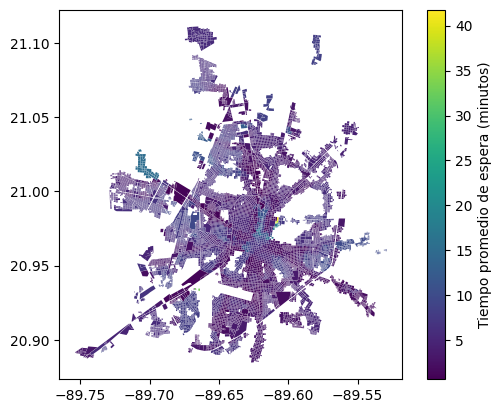

In [71]:
manzanas_tiempo_promedio.plot(column="mean_time", legend=True, cmap="viridis", legend_kwds={"label": "Tiempo promedio de espera (minutos)"})